In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using Optim
import ProgressMeter


In [2]:
import ReactiveMP.messageout

In [16]:
include("../helpers/data.jl")

generate_data

In [4]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [5]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [6]:
data_seed, params_seed = 42, 120

(42, 120)

In [7]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [8]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), 1e12*diageye(h_order)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    Ys = [Y*y_prev[i] for i in 1:n]
    Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Multivariate, h_order, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(order))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max_mv (generic function with 1 method)

In [9]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order), 0.1*diageye(h_order)), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                               observations_prev, controls,
                                                                               y_order, u_order, h_order,
                                                                               options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [10]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [11]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

LoadError: UndefVarError: generate_data not defined

In [12]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

LoadError: UndefVarError: y_obs not defined

In [13]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

LoadError: UndefVarError: observations_prev not defined

In [14]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = [randn(flow_param_len); [0.1, 1.0]]

47-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
  ⋮
 -1.2688151069939353
  0.5442892692759611
  0.9515135579177358
 -2.2502731970794416
 -1.8241177727907605
  0.5887138745053259
  0.6765822621496003
  0.29873821278434554
  0.35665768910493706
 -0.5512200526575644
  0.1
  1.0

In [15]:
@time fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=1);


LoadError: UndefVarError: Y_train not defined

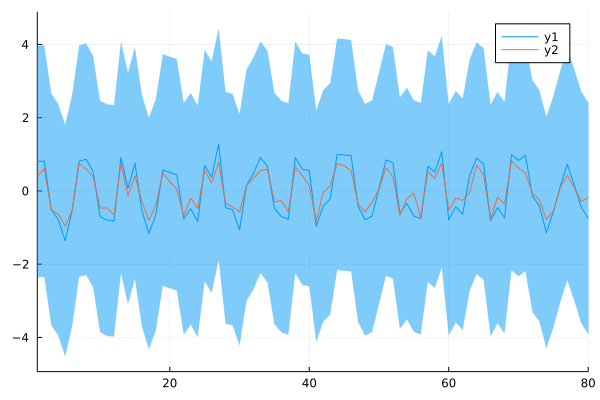

In [76]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

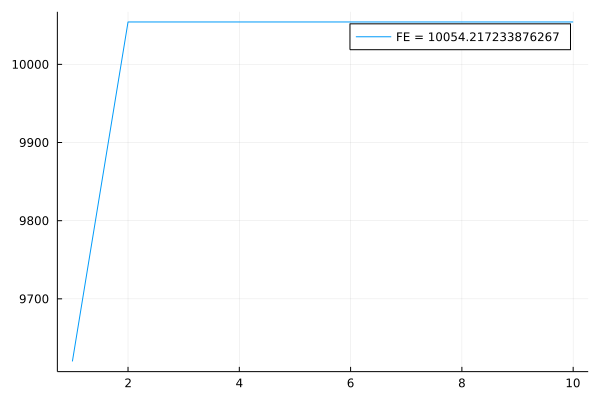

In [77]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [101]:
# Optimization function
function FE(params)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, params,
                                                             y_order=order_y, u_order=order_u, h_order=order_h,
                                                             h_prior=(zeros(order_h), 0.1*diageye(order_h)), vmp_its=1)
    return fe[end]
end;

In [108]:
using ReverseDiff

In [110]:
@time ForwardDiff.gradient(FE, model_params)

  3.323712 seconds (9.87 M allocations: 1.638 GiB, 23.30% gc time)


47-element Vector{Float64}:
    -29.341771273474826
     24.765303091541732
     47.83027413314785
    -13.239990575232348
    -10.965542852279782
      7.534760708901132
    -79.72413682259257
    191.7297365730821
     64.42966676949729
    -44.52725594004799
      0.27979549320188113
    -15.144664988132263
     25.177729056627072
      ⋮
      0.1608076984593083
    111.75948844257775
      4.261626065648514
      2.193293952596946
     61.32318890539594
    -67.0221934269492
     23.822716294469373
     38.183962739602364
     16.471805404202854
     -6.597082929314572
 -76006.84156248005
    286.0202241845807

In [ ]:
import ReactiveMP.fastcholesky
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [113]:
res = optimize(FE, model_params, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 1000, store_trace = true, show_trace = true, show_every=1), autodiff=:finite)

Iter     Function value   Gradient norm 
     0     9.619895e+03     7.600684e+04
 * time: 6.818771362304688e-5


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
        [1] [0m[1m(::ReactiveMP.var"#49#50"{ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}})[22m[0m[1m([22m[90mmessages[39m::[0mVector[90m{AbstractMessage}[39m[0m[1m)[22m
    [90m      @ [39m[35mReactiveMP[39m [90m~/.julia/packages/ReactiveMP/8eWsh/src/[39m[90;4mvariable.jl:55[0m
        [2] [0m[1mnext_received![22m[0m[1m([22m[90mwrapper[39m::[0mRocket.CollectLatestObservableWrapper[90m{AbstractMessage, Rocket.RecentSubjectInstance{Marginal, Subject{Marginal, AsapScheduler, AsapScheduler}}, Vector{AbstractMessage}, BitVector, Vector{Teardown}, ReactiveMP.var"#49#50"{ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}}}[39m, [90mdata[39m::[0mMessage[90m{NormalMeanVariance{Float64}}[39m, [90mindex[39m::[0mCartesianIndex[90m{1}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcollected.jl:95[0m
        [3] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcollected.jl:85[0m[90m [inlined][39m
        [4] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.CollectLatestObservableInnerActor[90m{AbstractMessage, CartesianIndex{1}, Rocket.CollectLatestObservableWrapper{AbstractMessage, Rocket.RecentSubjectInstance{Marginal, Subject{Marginal, AsapScheduler, AsapScheduler}}, Vector{AbstractMessage}, BitVector, Vector{Teardown}, ReactiveMP.var"#49#50"{ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}}}}[39m, [90mvalue[39m::[0mMessage[90m{NormalMeanVariance{Float64}}[39m, [90m#unused#[39m::[0mAsapScheduler[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/schedulers/[39m[90;4masap.jl:23[0m
        [5] [0m[1mon_next![22m[0m[1m([22m[90msubject[39m::[0mSubject[90m{AbstractMessage, AsapScheduler, AsapScheduler}[39m, [90mdata[39m::[0mMessage[90m{NormalMeanVariance{Float64}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4msubject.jl:62[0m
        [6] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
        [7] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m[90m [inlined][39m
        [8] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4mrecent.jl:62[0m[90m [inlined][39m
        [9] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.RecentSubjectInstance[90m{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}[39m, [90mvalue[39m::[0mMessage[90m{NormalMeanVariance{Float64}}[39m, [90minstance[39m::[0mReactiveMP.LimitStackScheduler[0m[1m)[22m
    [90m      @ [39m[35mReactiveMP[39m [90m~/.julia/packages/ReactiveMP/8eWsh/src/[39m[90;4mrocket.jl:56[0m
       [10] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:255[0m[90m [inlined][39m
       [11] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:203[0m[90m [inlined][39m
       [12] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mscheduled.jl:12[0m[90m [inlined][39m
       [13] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:206[0m[90m [inlined][39m
       [14] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/operators/[39m[90;4mmap.jl:60[0m[90m [inlined][39m
       [15] [0m[1mnext![22m[0m[1m([22m[90mactor[39m::[0mRocket.MapActor[90m{Tuple{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(dot), DataType, Marginalisation, DataType, Nothing, TinyCorrection, FactorNode{typeof(dot), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, TinyCorrection, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}[39m, [90mdata[39m::[0mTuple[90m{Tuple{Message{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}, Message{PointMass{Vector{Float64}}}}, Nothing}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:206[0m
       [16] [0m[1mnext_received![22m[0m[1m([22m[90mwrapper[39m::[0mRocket.CombineLatestActorWrapper[90m{Rocket.MStorage2{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.MapActor{Tuple{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(dot), DataType, Marginalisation, DataType, Nothing, TinyCorrection, FactorNode{typeof(dot), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, TinyCorrection, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}, PushNew, Rocket.UInt8UpdatesStatus}[39m, [90mdata[39m::[0mTuple[90m{Message{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}, Message{PointMass{Vector{Float64}}}}[39m, [90mindex[39m::[0mInt64[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcombined.jl:99[0m
       [17] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcombined.jl:66[0m[90m [inlined][39m
    [90m--- the last 3 lines are repeated 1 more time ---[39m
       [21] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.CombineLatestInnerActor[90m{Message, Rocket.CombineLatestActorWrapper{Rocket.MStorage2{Message, Message{PointMass{Vector{Float64}}}}, Rocket.CombineLatestInnerActor{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Rocket.CombineLatestActorWrapper{Rocket.MStorage2{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.MapActor{Tuple{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(dot), DataType, Marginalisation, DataType, Nothing, TinyCorrection, FactorNode{typeof(dot), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, TinyCorrection, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}, PushNew, Rocket.UInt8UpdatesStatus}}, PushNew, Rocket.UInt8UpdatesStatus}}[39m, [90mvalue[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90m#unused#[39m::[0mAsapScheduler[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/schedulers/[39m[90;4masap.jl:23[0m
       [22] [0m[1mon_next![22m[0m[1m([22m[90msubject[39m::[0mSubject[90m{Message, AsapScheduler, AsapScheduler}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4msubject.jl:62[0m
       [23] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
       [24] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m[90m [inlined][39m
       [25] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4mrecent.jl:62[0m[90m [inlined][39m
       [26] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
       [27] [0m[1mnext![22m[0m[1m([22m[90mactor[39m::[0mRocket.RecentSubjectInstance[90m{Message, Subject{Message, AsapScheduler, AsapScheduler}}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m
    [90m--- the last 26 lines are repeated 1 more time ---[39m
       [54] [0m[1mnext_received![22m[0m[1m([22m[90mwrapper[39m::[0mRocket.CollectLatestObservableWrapper[90m{AbstractMessage, Rocket.RecentSubjectInstance{Message, Subject{Message, AsapScheduler, AsapScheduler}}, Vector{AbstractMessage}, BitVector, Vector{Teardown}, ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90mindex[39m::[0mCartesianIndex[90m{1}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcollected.jl:95[0m
       [55] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcollected.jl:85[0m[90m [inlined][39m
       [56] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.CollectLatestObservableInnerActor[90m{AbstractMessage, CartesianIndex{1}, Rocket.CollectLatestObservableWrapper{AbstractMessage, Rocket.RecentSubjectInstance{Message, Subject{Message, AsapScheduler, AsapScheduler}}, Vector{AbstractMessage}, BitVector, Vector{Teardown}, ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}}}[39m, [90mvalue[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90m#unused#[39m::[0mAsapScheduler[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/schedulers/[39m[90;4masap.jl:23[0m
       [57] [0m[1mon_next![22m[0m[1m([22m[90msubject[39m::[0mSubject[90m{AbstractMessage, AsapScheduler, AsapScheduler}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4msubject.jl:62[0m
       [58] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
       [59] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m[90m [inlined][39m
       [60] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4mrecent.jl:62[0m[90m [inlined][39m
       [61] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.RecentSubjectInstance[90m{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}[39m, [90mvalue[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90minstance[39m::[0mReactiveMP.LimitStackScheduler[0m[1m)[22m
    [90m      @ [39m[35mReactiveMP[39m [90m~/.julia/packages/ReactiveMP/8eWsh/src/[39m[90;4mrocket.jl:56[0m
       [62] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:255[0m[90m [inlined][39m
       [63] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:203[0m[90m [inlined][39m
       [64] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mscheduled.jl:12[0m[90m [inlined][39m
       [65] [0m[1mnext![22m[0m[1m([22m[90mactor[39m::[0mRocket.ScheduledActor[90m{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:206[0m
       [66] [0m[1mon_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.MapActor[90m{Tuple{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(+), DataType, Marginalisation, DataType, Nothing, Nothing, FactorNode{typeof(+), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, Nothing, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}[39m, [90mdata[39m::[0mTuple[90m{Tuple{Message{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}, Message{PointMass{Vector{Float64}}}}, Nothing}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/operators/[39m[90;4mmap.jl:60[0m
       [67] [0m[1mnext![22m[0m[1m([22m[90mactor[39m::[0mRocket.MapActor[90m{Tuple{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(+), DataType, Marginalisation, DataType, Nothing, Nothing, FactorNode{typeof(+), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, Nothing, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}[39m, [90mdata[39m::[0mTuple[90m{Tuple{Message{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}, Message{PointMass{Vector{Float64}}}}, Nothing}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:206[0m
       [68] [0m[1mnext_received![22m[0m[1m([22m[90mwrapper[39m::[0mRocket.CombineLatestActorWrapper[90m{Rocket.MStorage2{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.MapActor{Tuple{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(+), DataType, Marginalisation, DataType, Nothing, Nothing, FactorNode{typeof(+), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, Nothing, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}, PushNew, Rocket.UInt8UpdatesStatus}[39m, [90mdata[39m::[0mTuple[90m{Message{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}, Message{PointMass{Vector{Float64}}}}[39m, [90mindex[39m::[0mInt64[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcombined.jl:99[0m
       [69] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcombined.jl:66[0m[90m [inlined][39m
    [90m--- the last 3 lines are repeated 1 more time ---[39m
       [73] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.CombineLatestInnerActor[90m{Message, Rocket.CombineLatestActorWrapper{Rocket.MStorage2{Message, Message{PointMass{Vector{Float64}}}}, Rocket.CombineLatestInnerActor{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Rocket.CombineLatestActorWrapper{Rocket.MStorage2{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.MapActor{Tuple{Tuple{Message, Message{PointMass{Vector{Float64}}}}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(+), DataType, Marginalisation, DataType, Nothing, Nothing, FactorNode{typeof(+), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, Nothing, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}, PushNew, Rocket.UInt8UpdatesStatus}}, PushNew, Rocket.UInt8UpdatesStatus}}[39m, [90mvalue[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90m#unused#[39m::[0mAsapScheduler[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/schedulers/[39m[90;4masap.jl:23[0m
       [74] [0m[1mon_next![22m[0m[1m([22m[90msubject[39m::[0mSubject[90m{Message, AsapScheduler, AsapScheduler}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4msubject.jl:62[0m
       [75] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
       [76] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m[90m [inlined][39m
       [77] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4mrecent.jl:62[0m[90m [inlined][39m
       [78] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
       [79] [0m[1mnext![22m[0m[1m([22m[90mactor[39m::[0mRocket.RecentSubjectInstance[90m{Message, Subject{Message, AsapScheduler, AsapScheduler}}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m
    [90m--- the last 26 lines are repeated 1 more time ---[39m
      [106] [0m[1mnext_received![22m[0m[1m([22m[90mwrapper[39m::[0mRocket.CollectLatestObservableWrapper[90m{AbstractMessage, Rocket.RecentSubjectInstance{Message, Subject{Message, AsapScheduler, AsapScheduler}}, Vector{AbstractMessage}, BitVector, Vector{Teardown}, ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90mindex[39m::[0mCartesianIndex[90m{1}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcollected.jl:95[0m
      [107] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcollected.jl:85[0m[90m [inlined][39m
      [108] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.CollectLatestObservableInnerActor[90m{AbstractMessage, CartesianIndex{1}, Rocket.CollectLatestObservableWrapper{AbstractMessage, Rocket.RecentSubjectInstance{Message, Subject{Message, AsapScheduler, AsapScheduler}}, Vector{AbstractMessage}, BitVector, Vector{Teardown}, ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}}}[39m, [90mvalue[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90m#unused#[39m::[0mAsapScheduler[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/schedulers/[39m[90;4masap.jl:23[0m
      [109] [0m[1mon_next![22m[0m[1m([22m[90msubject[39m::[0mSubject[90m{AbstractMessage, AsapScheduler, AsapScheduler}[39m, [90mdata[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4msubject.jl:62[0m
      [110] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
      [111] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m[90m [inlined][39m
      [112] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4mrecent.jl:62[0m[90m [inlined][39m
      [113] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.RecentSubjectInstance[90m{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}[39m, [90mvalue[39m::[0mMessage[90m{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90minstance[39m::[0mReactiveMP.LimitStackScheduler[0m[1m)[22m
    [90m      @ [39m[35mReactiveMP[39m [90m~/.julia/packages/ReactiveMP/8eWsh/src/[39m[90;4mrocket.jl:56[0m
      [114] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:255[0m[90m [inlined][39m
      [115] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:203[0m[90m [inlined][39m
      [116] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mscheduled.jl:12[0m[90m [inlined][39m
      [117] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:206[0m[90m [inlined][39m
      [118] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/operators/[39m[90;4mmap.jl:60[0m[90m [inlined][39m
      [119] [0m[1mnext![22m[0m[1m([22m[90mactor[39m::[0mRocket.MapActor[90m{Tuple{Tuple{Message{PointMass{Matrix{Float64}}}, Message}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(*), DataType, Marginalisation, DataType, Nothing, TinyCorrection, FactorNode{typeof(*), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, TinyCorrection, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}[39m, [90mdata[39m::[0mTuple[90m{Tuple{Message{PointMass{Matrix{Float64}}}, Message{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}}, Nothing}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:206[0m
      [120] [0m[1mnext_received![22m[0m[1m([22m[90mwrapper[39m::[0mRocket.CombineLatestActorWrapper[90m{Rocket.MStorage2{Tuple{Message{PointMass{Matrix{Float64}}}, Message}, Nothing}, Rocket.MapActor{Tuple{Tuple{Message{PointMass{Matrix{Float64}}}, Message}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(*), DataType, Marginalisation, DataType, Nothing, TinyCorrection, FactorNode{typeof(*), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, TinyCorrection, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}, PushNew, Rocket.UInt8UpdatesStatus}[39m, [90mdata[39m::[0mTuple[90m{Message{PointMass{Matrix{Float64}}}, Message{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}}[39m, [90mindex[39m::[0mInt64[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcombined.jl:99[0m
      [121] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcombined.jl:66[0m[90m [inlined][39m
    [90m--- the last 3 lines are repeated 1 more time ---[39m
      [125] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.CombineLatestInnerActor[90m{Message, Rocket.CombineLatestActorWrapper{Rocket.MStorage2{Message{PointMass{Matrix{Float64}}}, Message}, Rocket.CombineLatestInnerActor{Tuple{Message{PointMass{Matrix{Float64}}}, Message}, Rocket.CombineLatestActorWrapper{Rocket.MStorage2{Tuple{Message{PointMass{Matrix{Float64}}}, Message}, Nothing}, Rocket.MapActor{Tuple{Tuple{Message{PointMass{Matrix{Float64}}}, Message}, Nothing}, Rocket.ScheduledActor{AbstractMessage, ReactiveMP.LimitStackScheduler, Rocket.RecentSubjectInstance{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}}, ReactiveMP.MessageMapping{typeof(*), DataType, Marginalisation, DataType, Nothing, TinyCorrection, FactorNode{typeof(*), Tuple{NodeInterface, NodeInterface, NodeInterface}, Tuple{Tuple{Int64, Int64, Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal}}, TinyCorrection, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}, PushNew, Rocket.UInt8UpdatesStatus}}, PushNew, Rocket.UInt8UpdatesStatus}}[39m, [90mvalue[39m::[0mMessage[90m{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}[39m, [90m#unused#[39m::[0mAsapScheduler[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/schedulers/[39m[90;4masap.jl:23[0m
      [126] [0m[1mon_next![22m[0m[1m([22m[90msubject[39m::[0mSubject[90m{Message, AsapScheduler, AsapScheduler}[39m, [90mdata[39m::[0mMessage[90m{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4msubject.jl:62[0m
      [127] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
      [128] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m[90m [inlined][39m
      [129] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4mrecent.jl:62[0m[90m [inlined][39m
      [130] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
      [131] [0m[1mnext![22m[0m[1m([22m[90mactor[39m::[0mRocket.RecentSubjectInstance[90m{Message, Subject{Message, AsapScheduler, AsapScheduler}}[39m, [90mdata[39m::[0mMessage[90m{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m
    [90m--- the last 26 lines are repeated 98 more times ---[39m
     [2680] [0m[1mnext_received![22m[0m[1m([22m[90mwrapper[39m::[0mRocket.CollectLatestObservableWrapper[90m{AbstractMessage, Rocket.RecentSubjectInstance{Message, Subject{Message, AsapScheduler, AsapScheduler}}, Vector{AbstractMessage}, BitVector, Vector{Teardown}, ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}}[39m, [90mdata[39m::[0mVariationalMessage[90m{Tuple{Message{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}}, Tuple{ReactiveMP.MarginalObservable, ReactiveMP.MarginalObservable}, ReactiveMP.MessageMapping{AR, DataType, Marginalisation, DataType, DataType, ARMeta{Multivariate, ARsafe}, FactorNode{Type{AR}, NTuple{4, NodeInterface}, Tuple{Tuple{Int64, Int64}, Tuple{Int64}, Tuple{Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal, ReactiveMP.FactorNodeLocalMarginal, ReactiveMP.FactorNodeLocalMarginal}}, ARMeta{Multivariate, ARsafe}, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}[39m, [90mindex[39m::[0mCartesianIndex[90m{1}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcollected.jl:95[0m
     [2681] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/observable/[39m[90;4mcollected.jl:85[0m[90m [inlined][39m
     [2682] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.CollectLatestObservableInnerActor[90m{AbstractMessage, CartesianIndex{1}, Rocket.CollectLatestObservableWrapper{AbstractMessage, Rocket.RecentSubjectInstance{Message, Subject{Message, AsapScheduler, AsapScheduler}}, Vector{AbstractMessage}, BitVector, Vector{Teardown}, ReactiveMP.var"#23#25"{ProdAnalytical, UnspecifiedFormConstraint}}}[39m, [90mvalue[39m::[0mVariationalMessage[90m{Tuple{Message{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}}, Tuple{ReactiveMP.MarginalObservable, ReactiveMP.MarginalObservable}, ReactiveMP.MessageMapping{AR, DataType, Marginalisation, DataType, DataType, ARMeta{Multivariate, ARsafe}, FactorNode{Type{AR}, NTuple{4, NodeInterface}, Tuple{Tuple{Int64, Int64}, Tuple{Int64}, Tuple{Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal, ReactiveMP.FactorNodeLocalMarginal, ReactiveMP.FactorNodeLocalMarginal}}, ARMeta{Multivariate, ARsafe}, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}[39m, [90m#unused#[39m::[0mAsapScheduler[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/schedulers/[39m[90;4masap.jl:23[0m
     [2683] [0m[1mon_next![22m[0m[1m([22m[90msubject[39m::[0mSubject[90m{AbstractMessage, AsapScheduler, AsapScheduler}[39m, [90mdata[39m::[0mVariationalMessage[90m{Tuple{Message{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}}, Tuple{ReactiveMP.MarginalObservable, ReactiveMP.MarginalObservable}, ReactiveMP.MessageMapping{AR, DataType, Marginalisation, DataType, DataType, ARMeta{Multivariate, ARsafe}, FactorNode{Type{AR}, NTuple{4, NodeInterface}, Tuple{Tuple{Int64, Int64}, Tuple{Int64}, Tuple{Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal, ReactiveMP.FactorNodeLocalMarginal, ReactiveMP.FactorNodeLocalMarginal}}, ARMeta{Multivariate, ARsafe}, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}[39m[0m[1m)[22m
    [90m      @ [39m[36mRocket[39m [90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4msubject.jl:62[0m
     [2684] [0m[1mactor_on_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:250[0m[90m [inlined][39m
     [2685] [0m[1mnext![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/[39m[90;4mactor.jl:202[0m[90m [inlined][39m
     [2686] [0m[1mon_next![22m
    [90m      @ [39m[90m~/.julia/packages/Rocket/HPmEm/src/subjects/[39m[90;4mrecent.jl:62[0m[90m [inlined][39m
     [2687] [0m[1mscheduled_next![22m[0m[1m([22m[90mactor[39m::[0mRocket.RecentSubjectInstance[90m{AbstractMessage, Subject{AbstractMessage, AsapScheduler, AsapScheduler}}[39m, [90mvalue[39m::[0mVariationalMessage[90m{Tuple{Message{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}}, Tuple{ReactiveMP.MarginalObservable, ReactiveMP.MarginalObservable}, ReactiveMP.MessageMapping{AR, DataType, Marginalisation, DataType, DataType, ARMeta{Multivariate, ARsafe}, FactorNode{Type{AR}, NTuple{4, NodeInterface}, Tuple{Tuple{Int64, Int64}, Tuple{Int64}, Tuple{Int64}}, ReactiveMP.FactorNodeLocalMarginals{Tuple{ReactiveMP.FactorNodeLocalMarginal, ReactiveMP.FactorNodeLocalMarginal, ReactiveMP.FactorNodeLocalMarginal}}, ARMeta{Multivariate, ARsafe}, ReactiveMP.FactorNodePipeline{DefaultFunctionalDependencies, EmptyPipelineStage}}}}[39m, [90minstance[39m::[0mReactiveMP.LimitStackScheduler[0m[1m)[22m
    [90m      @ [39m[35mReactiveMP[39m [90m~/.julia/packages/ReactiveMP/8eWsh/src/[39m[90;4mrocket.jl:56[0m

In [69]:
inf_params = Optim.minimizer(res)


47-element Vector{Float64}:
  0.16117611845454027
 -0.9226425638117133
 -0.1158510729843248
 -1.1745953277726122
 -3.5061705702372294
 -0.2982821796668494
  2.3724135285666623
 -2.973145752160475
  3.4880947440949974
  2.639866755768722
 -0.6889136195901198
  0.1165105159713987
  0.7399825449105533
  ⋮
  1.228960001435283
  1.4350747849754453
  2.289840889231683
 -1.3748742343472766
 -6.443705334555895
  1.2100594688829638
 -0.9917845638150997
  0.9300389720250417
 -0.6619754529219903
 -0.06429838018079578
  8.559890543258586
  6.701013573907724

In [78]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params,
                                                                y_order=order_y, u_order=order_u, h_order=order_h,
                                                                h_prior=(zeros(order_h), 0.1*diageye(order_h)), vmp_its=10);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


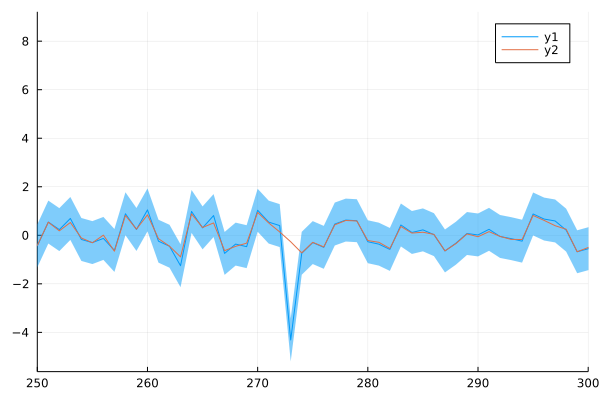

In [80]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(250, 300))

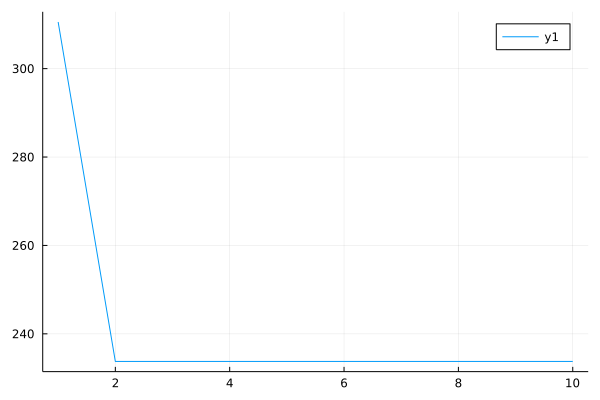

In [81]:
plot(fe_)

### KF-like prediction

In [60]:
function transition(γ, order)
#     V = zeros(order, order)
    V = 1e-12*diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [61]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(model_flow::FlowModel, params, w, h_prior, y_prev, u, full_order)
    
    h_order = length(h_prior[1])

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(full_order))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 1 method)

In [62]:
function nonlinear_max_prediction_mv(observation_prev, control, model_flow::FlowModel, params; full_order, 
                                     h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50)

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_mv_model(model_flow, params, w, h_prior,
                                                                                             observation_prev, control, full_order,
                                                                                             options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 1 method)

In [63]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction_mv(X_test[i], U_test[i], model_flow, inf_params, full_order=full_order, h_prior=h_prev, w=ŵ, vmp_its=10)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, h_prior=h_prev, vmp_its=10);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [64]:
mx, vx = mean.(predictions), cov.(predictions);

In [65]:
test_from, test_to = 150, 200

(150, 200)

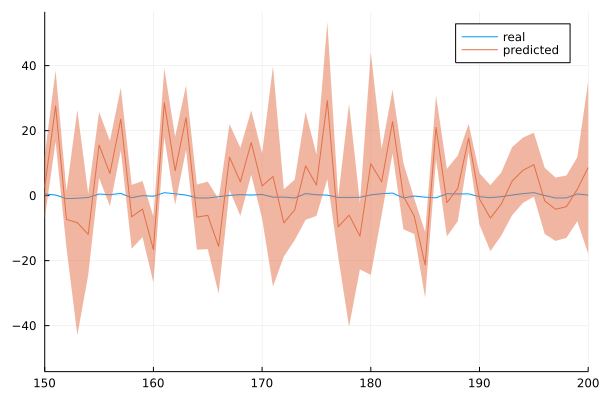

In [66]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")